# Credit Card Fraud Detection

## Download dataset and extract

In [ ]:
!curl -L -o creditcardfraud.zip https://www.kaggle.com/api/v1/datasets/download/mlg-ulb/creditcardfraud

In [ ]:
import zipfile

with zipfile.ZipFile("creditcardfraud.zip", "r") as zip_ref:
    zip_ref.extractall(".")

## Dataset preprocessing

In [257]:
import numpy as np
import pandas as pd
# import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [258]:
df = pd.read_csv('./creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [259]:
df.columns[df.isnull().sum()>0]

Index([], dtype='object')

Class
0    284315
1       492
Name: count, dtype: int64

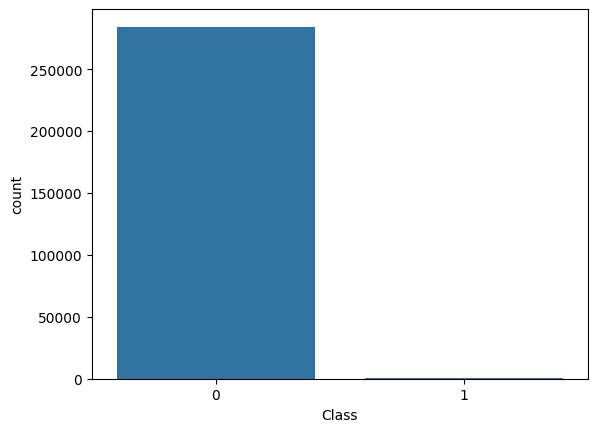

In [260]:
sns.countplot(x='Class', data=df)
df['Class'].value_counts()

In [261]:

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['Amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

In [262]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,0
2,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0
3,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,0
4,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,0


In [263]:
df = df.sample(frac=1, random_state=42)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
df = normal_distributed_df.sample(frac=1, random_state=42)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
146884,0.038170,2.054361,-0.122642,-1.245717,0.189567,0.132497,-0.620765,0.059581,-0.148058,0.338940,...,-0.271204,-0.687048,0.271569,-0.497120,-0.270115,0.208619,-0.076075,-0.075428,-0.293579,0
95597,-0.226824,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,-1.016592,...,-0.511657,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,18.615944,1
96768,-0.220456,0.955253,-0.833374,0.847147,0.725970,-1.322868,-0.238842,-0.565347,0.022443,-0.762247,...,-0.110554,-0.129397,-0.040892,0.364872,0.204756,-0.304578,0.055908,0.062489,1.872424,0
75511,-0.335930,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,-1.184468,...,1.208054,0.277612,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,2.080905,1
255556,0.852830,-0.242245,4.147186,-5.672349,6.493741,1.591168,-1.602523,-0.950463,0.722903,-4.128505,...,0.249023,-0.480286,-0.286080,-1.153575,-0.035571,0.559628,0.409446,0.221048,-0.296653,1


Class
0    492
1    492
Name: count, dtype: int64

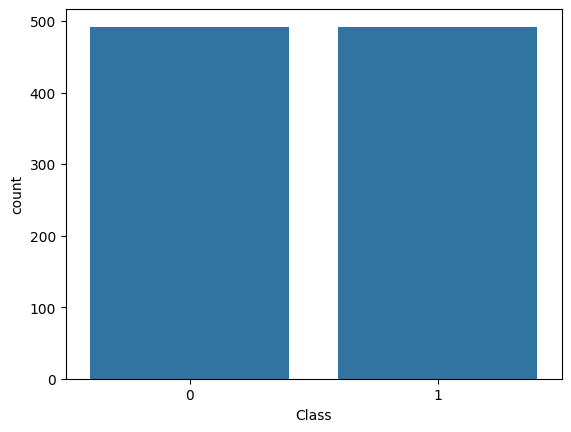

In [264]:
sns.countplot(x='Class', data=df)
df['Class'].value_counts()

<Axes: >

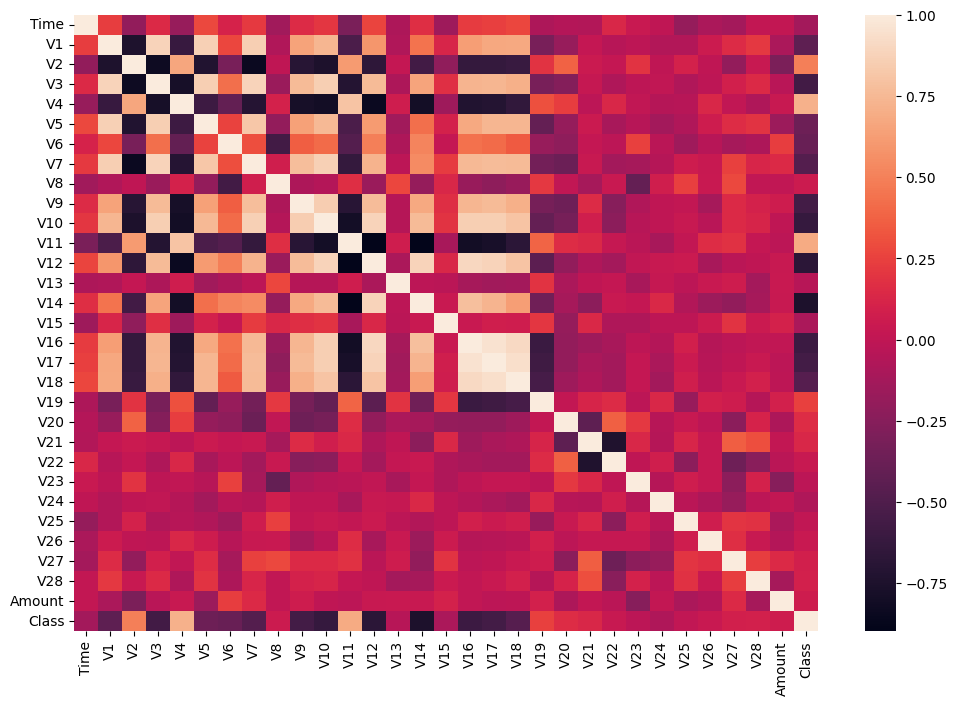

In [265]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr())

<Axes: >

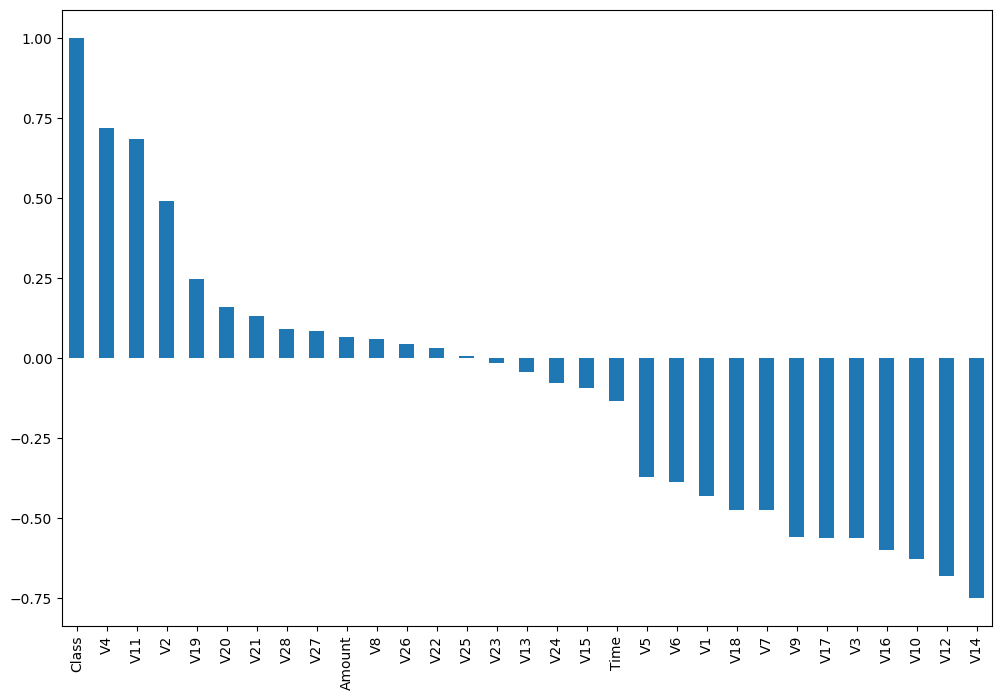

In [266]:
df.corr()['Class'].sort_values(ascending=False).plot(kind='bar',figsize=(12,8))

<Axes: xlabel='Class', ylabel='V11'>

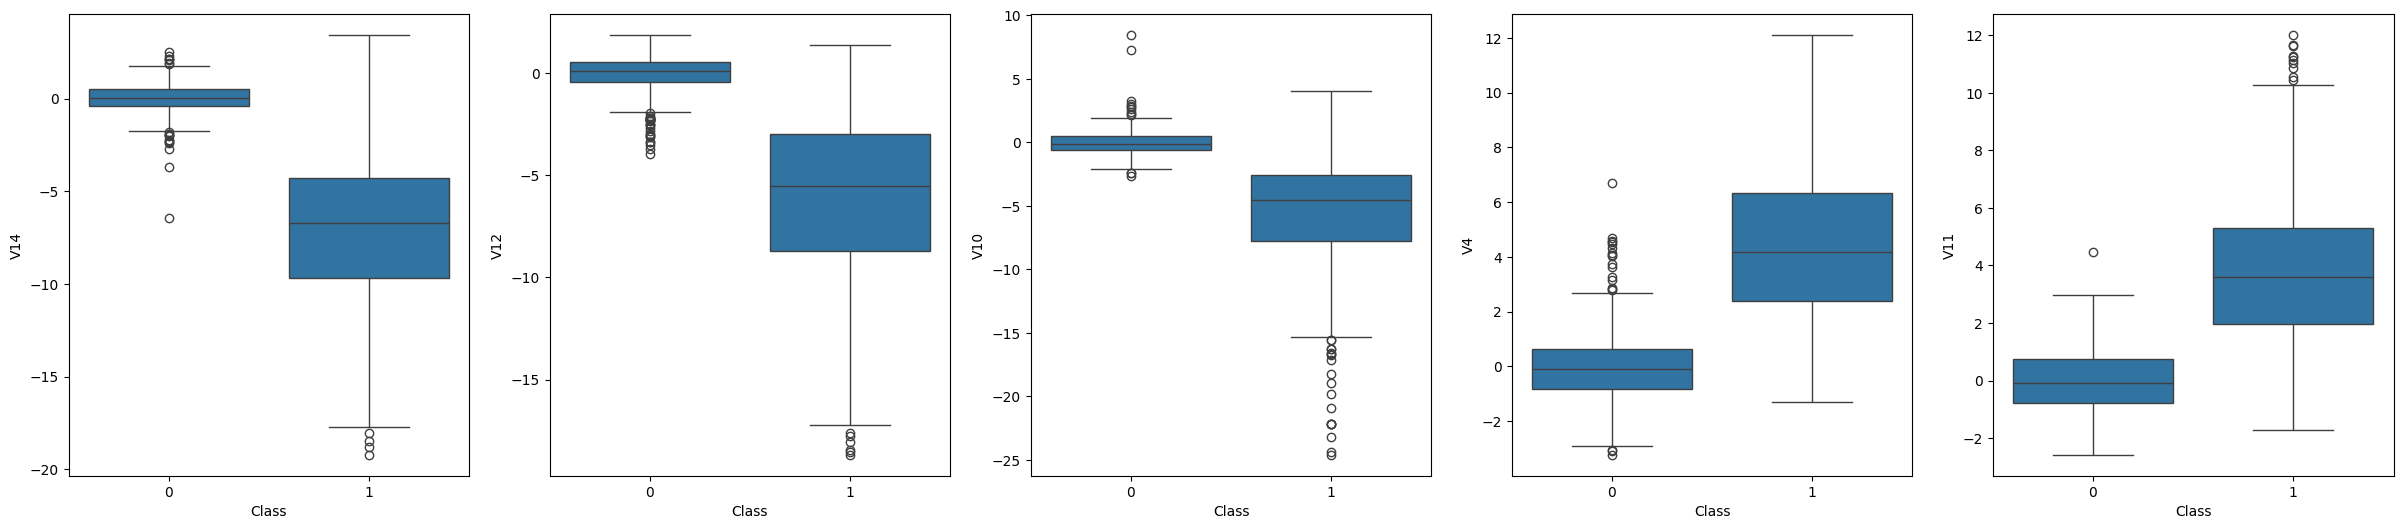

In [267]:
f, axes = plt.subplots(ncols=5, figsize=(30,6))
sns.boxplot(x='Class',y='V14',data=df, ax=axes[0])
sns.boxplot(x='Class',y='V12',data=df, ax=axes[1])
sns.boxplot(x='Class',y='V10',data=df,  ax=axes[2])
sns.boxplot(x='Class',y='V4',data=df, ax=axes[3])
sns.boxplot(x='Class',y='V11',data=df, ax=axes[4])

<Axes: xlabel='Class', ylabel='V4'>

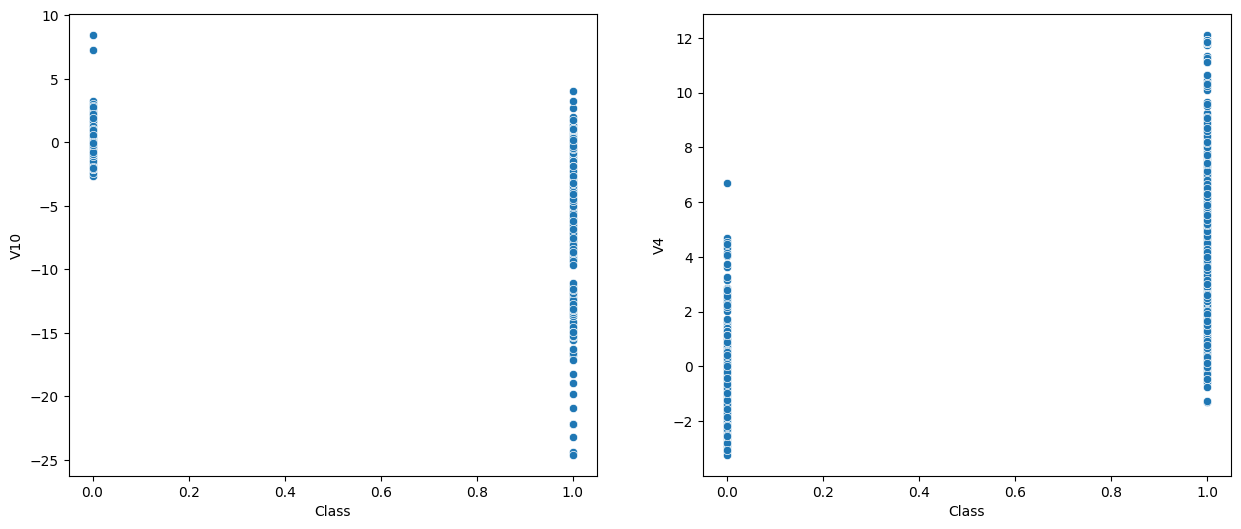

In [268]:
f, axes = plt.subplots(ncols=2, figsize=(15,6))
sns.scatterplot(x='Class',y='V10',data=df, ax=axes[0])
sns.scatterplot(x='Class',y='V4',data=df, ax=axes[1])

In [269]:
ind_drop = df[((df['Class']==0) & (df['V10']>5)) | ((df['Class']==0) & (df['V4']>6))]
ind_drop

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
219257,0.669216,-29.942972,-25.831782,-16.227512,6.690679,-20.787846,13.085694,17.256623,-9.161746,5.003041,...,-2.494699,-0.660297,-8.537816,0.400804,-0.643023,0.496903,6.267709,-2.765070,48.628659,0
113740,-0.135199,-5.136552,5.746647,-3.838599,-0.329163,1.288327,0.251632,1.442205,-0.379463,5.509988,...,-1.291890,0.247433,0.182054,-1.486916,0.106656,-0.649515,-0.708468,-2.730412,-0.296374,0
163198,0.364736,-4.246957,3.611999,-1.001048,-1.898896,-0.024881,-0.990749,1.830940,-0.910006,4.683439,...,-1.288588,-0.716005,-0.012903,-0.056522,0.079643,-0.157399,-0.535060,-1.870915,-0.056033,0


In [270]:
df = df.drop(ind_drop.index)

In [271]:
X = df.drop('Class', axis=1)
y = df['Class']

In [272]:
X.shape,y.shape

((981, 30), (981,))

In [273]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
146884,0.038170,2.054361,-0.122642,-1.245717,0.189567,0.132497,-0.620765,0.059581,-0.148058,0.338940,...,-0.209856,-0.271204,-0.687048,0.271569,-0.497120,-0.270115,0.208619,-0.076075,-0.075428,-0.293579
95597,-0.226824,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,-1.016592,...,-0.447039,-0.511657,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,18.615944
96768,-0.220456,0.955253,-0.833374,0.847147,0.725970,-1.322868,-0.238842,-0.565347,0.022443,-0.762247,...,-0.294785,-0.110554,-0.129397,-0.040892,0.364872,0.204756,-0.304578,0.055908,0.062489,1.872424
75511,-0.335930,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,-1.184468,...,0.270459,1.208054,0.277612,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,2.080905
255556,0.852830,-0.242245,4.147186,-5.672349,6.493741,1.591168,-1.602523,-0.950463,0.722903,-4.128505,...,0.562030,0.249023,-0.480286,-0.286080,-1.153575,-0.035571,0.559628,0.409446,0.221048,-0.296653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239499,0.768877,-2.150855,2.187917,-3.430516,0.119476,-0.173210,0.290700,-2.808988,-2.679351,-0.556685,...,0.532145,-0.073205,0.561496,-0.075034,-0.437619,0.353841,-0.521339,0.144465,0.026588,0.391253
43624,-0.506467,-1.048005,1.300219,-0.180401,2.589843,-1.164794,0.031823,-2.175778,0.699072,-1.140208,...,0.644993,0.549014,0.624321,-0.136663,0.131738,0.030921,-0.176701,0.504898,0.069882,0.243834
103626,-0.187432,-3.599934,4.022775,-2.735797,0.416448,-0.546681,1.114840,-3.332706,-3.035458,-2.103863,...,1.173588,-2.353510,0.747557,0.369075,-1.460187,-0.041429,0.497594,-0.623617,0.009661,-0.296793
119714,-0.107332,-0.734303,0.435519,-0.530866,-0.471120,0.643214,0.713832,-1.234572,-2.551412,-2.057724,...,0.864536,-1.004877,1.150354,-0.152555,-1.386745,0.004716,0.219146,-0.058257,0.158048,0.111088


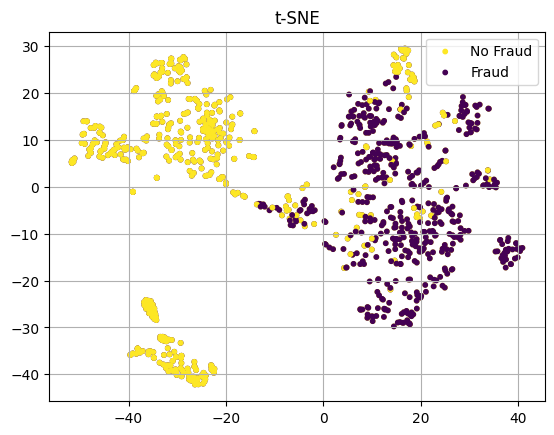

In [274]:
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
plt.grid(True)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), s=10, label='No Fraud')
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), s=10, label='Fraud')
plt.title('t-SNE')
plt.legend()
plt.show()


In [275]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Utility function for calculating metrics

In [276]:
def cal_metrics(model, X_test, y_test):
    print("best_params_ = {}".format(model.best_params_))
    print("best_score_ = {}".format(model.best_score_))
    
    y_pred = model.predict(X_test)
    print("accuracy_score = {}".format(accuracy_score(y_test,y_pred)))
    print(classification_report(y_test,y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true')

    # calculate ROC
    y_prob = y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    plt.show()

## Train/Test logistic regression model

In [277]:
log_model = LogisticRegression(solver='saga',max_iter=5000)
# Penalty Type
penalty = ['l1', 'l2']

# Use logarithmically spaced C values (recommended in official docs)
C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
grid_model = GridSearchCV(log_model,param_grid={'C':C,'penalty':penalty})
grid_model.fit(X_train,y_train)

D:\miniconda3\envs\sep_proj\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\miniconda3\envs\sep_proj\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\miniconda3\envs\sep_proj\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\miniconda3\envs\sep_proj\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(max_iter=5000, solver='saga'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

best_params_ = {'C': 0.1, 'penalty': 'l2'}
best_score_ = 0.9464559856279602
accuracy_score = 0.949238578680203
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        98
           1       0.96      0.94      0.95        99

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



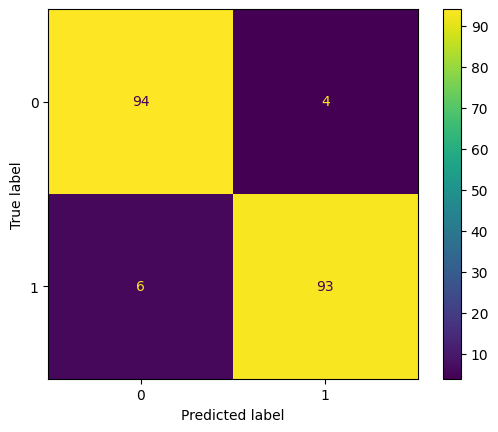

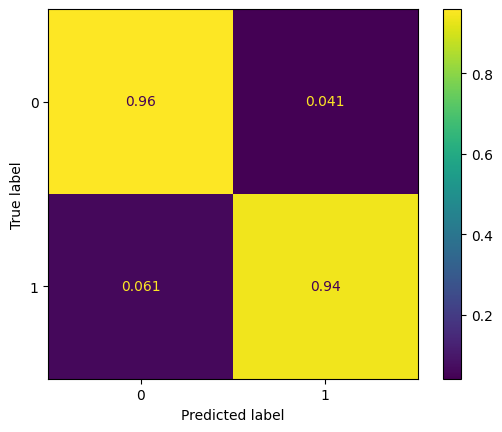

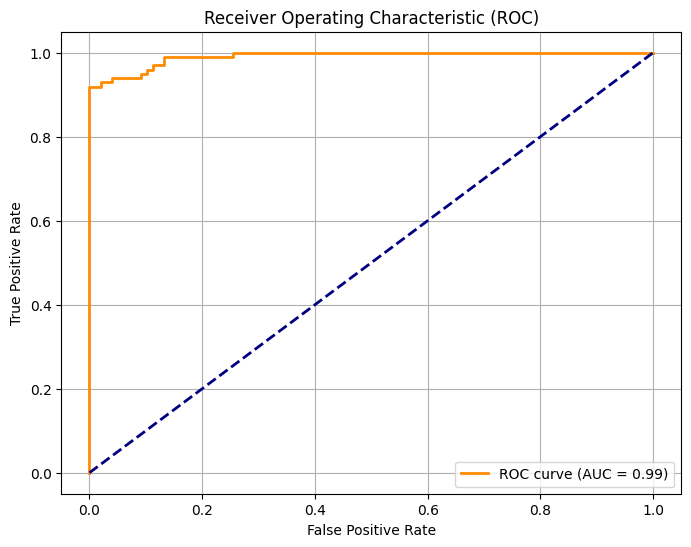

In [278]:
cal_metrics(grid_model, X_test, y_test)

## Train/Test SVM model

In [279]:
from sklearn.svm import SVC

In [280]:
svc_model = SVC(probability=True)

param_grid = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_model = GridSearchCV(svc_model,param_grid)
grid_model.fit(X_train,y_train)
# grid_model.fit(X,y)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']})

best_params_ = {'C': 0.1, 'kernel': 'linear'}
best_score_ = 0.9451657684141761
accuracy_score = 0.9441624365482234
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        98
           1       0.96      0.93      0.94        99

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



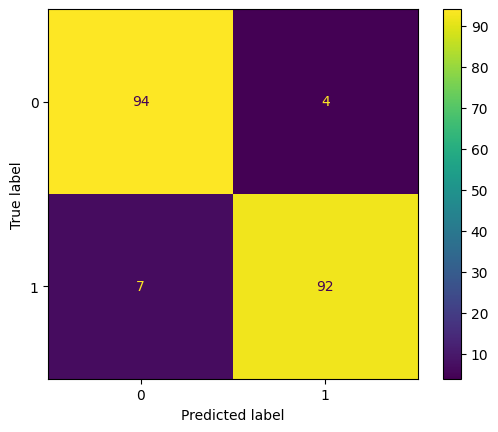

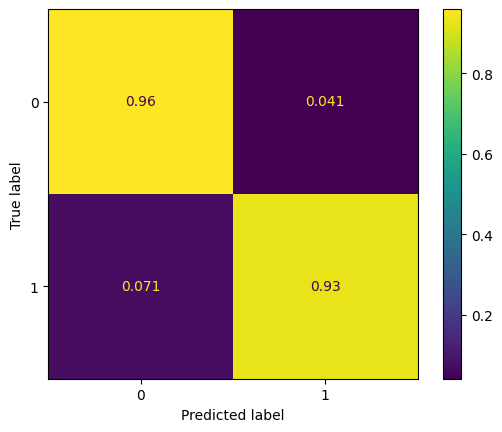

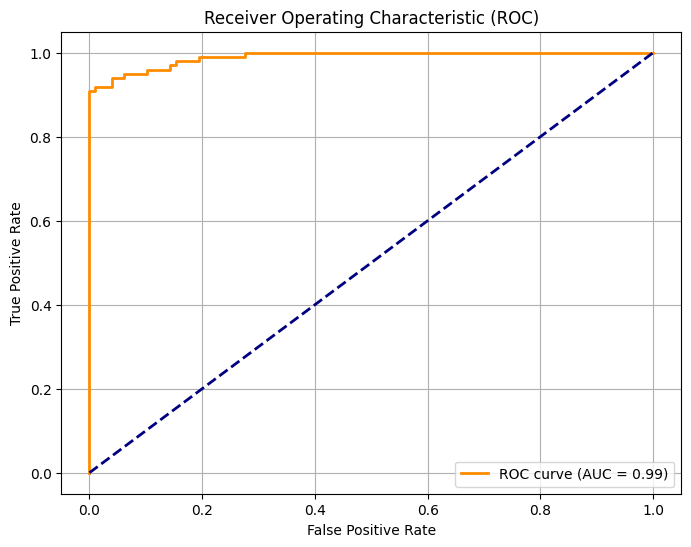

In [281]:
cal_metrics(grid_model, X_test, y_test)

## Train/Test decision tree model

In [282]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

In [283]:
decision_tree_model = DecisionTreeClassifier(random_state=42)

param_grid = {'max_leaf_nodes': range(2, 21), 'criterion': ['gini', 'entropy', 'log_loss']}
grid_model = GridSearchCV(decision_tree_model,param_grid)
grid_model.fit(X_train,y_train)
# grid_model.fit(X,y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_leaf_nodes': range(2, 21)})

best_params_ = {'criterion': 'entropy', 'max_leaf_nodes': 11}
best_score_ = 0.9324105830475258
accuracy_score = 0.934010152284264
              precision    recall  f1-score   support

           0       0.91      0.96      0.94        98
           1       0.96      0.91      0.93        99

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197



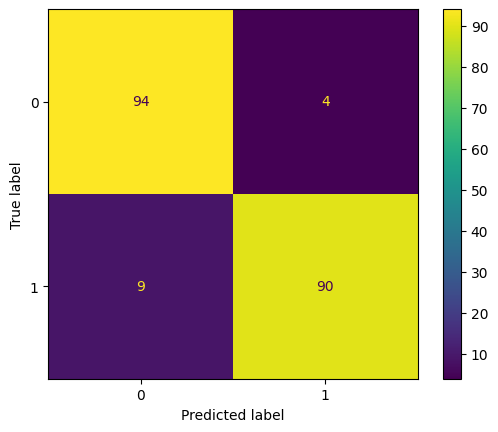

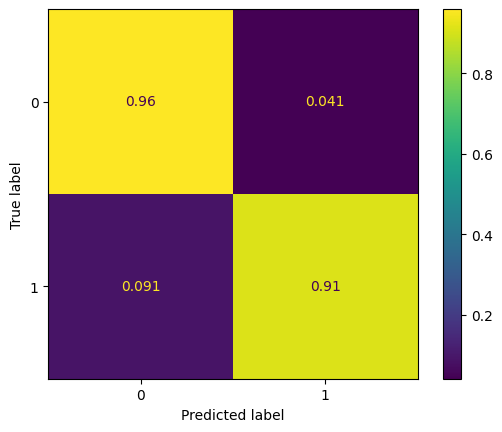

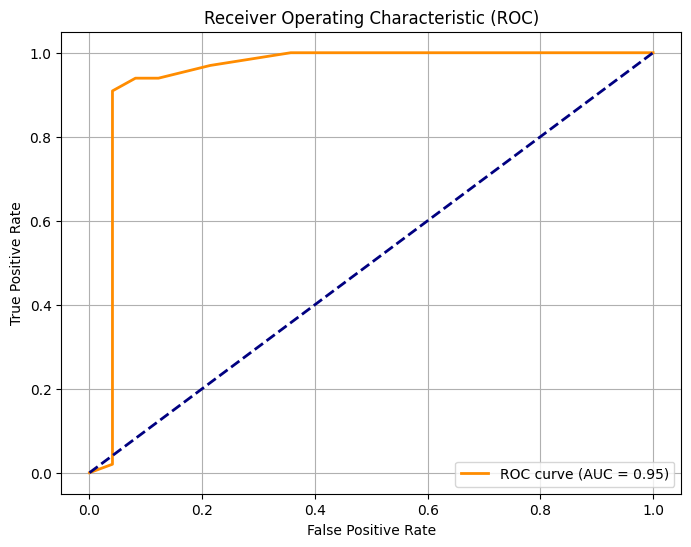

In [284]:
cal_metrics(grid_model, X_test, y_test)

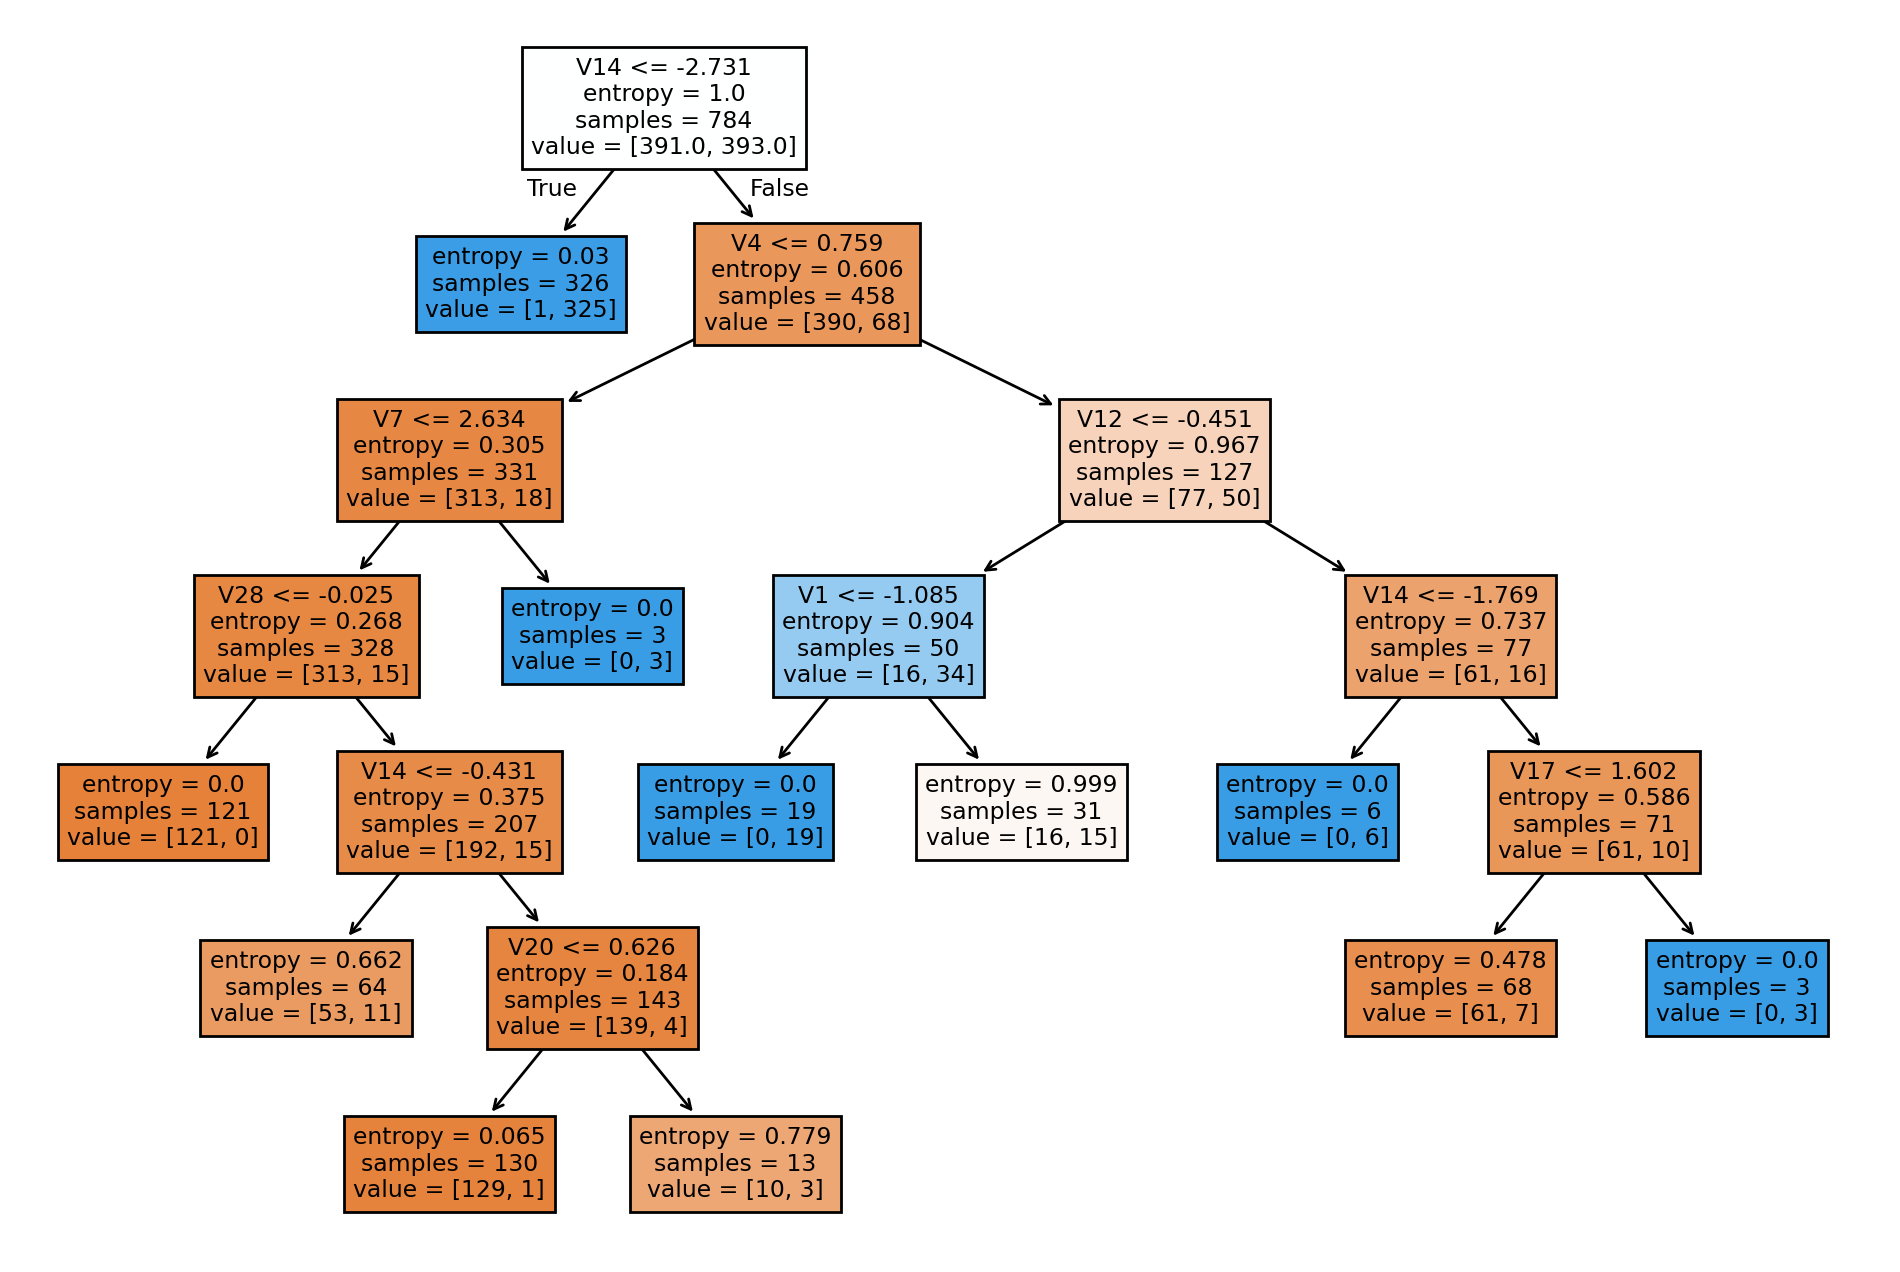

In [285]:
plt.figure(figsize=(12,8), dpi=200)
plot_tree(grid_model.best_estimator_,filled=True,feature_names=X.columns);